In [43]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch
import matplotlib.pyplot as plt
import diff_unet
# reload diff_unet package
import importlib
importlib.reload(diff_unet)

batch_size = 1
subs = 1

torch.manual_seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = MNIST('./data', train=True, download=True, transform=transform)

# Create dataset of 10 images
mnist = torch.utils.data.Subset(mnist, range(subs))
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

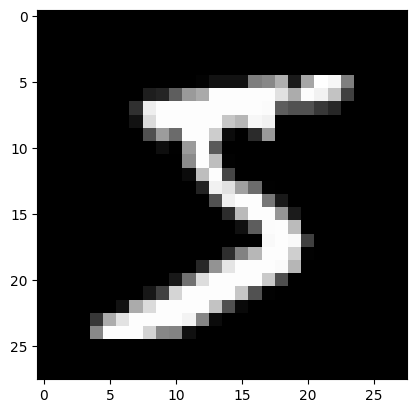

In [44]:
plt.imshow(next(iter(data_loader))[0][0].numpy().squeeze(), cmap='gray');

In [45]:
from diff_unet import Unet, linear_beta_schedule, cosine_beta_schedule

img = next(iter(data_loader))[0]
T = 200
t = torch.randint(0, T, (batch_size,))

batch_size, channels, height, width = img.shape

unet = Unet(dim=height,
            channels=channels,
            dim_mults=(1,2,4),
            resnet_block_groups=7,
            use_convnext=False,
            timesteps=T,
            schedule_f=cosine_beta_schedule,)

from torchinfo import summary

# summary(unet, [(batch_size, channels, height, width), (batch_size,)], depth=2)

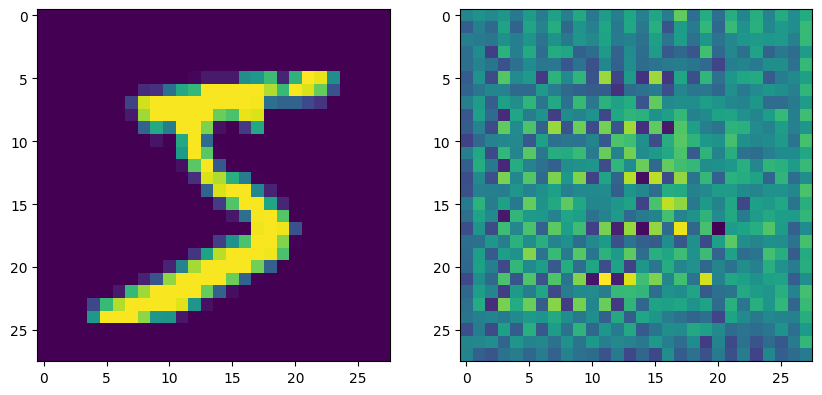

In [46]:
import matplotlib.pyplot as plt

out = unet(img, t)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0, 0, :, :].detach().numpy());
ax[1].imshow(out[0, 0, :, :].detach().numpy());

In [47]:
from torch.optim import Adam

optimizer = Adam(unet.parameters(), lr=1e-3)

Epoch 499: 100%|██████████| 500/500 [00:25<00:00, 19.63it/s, loss=0.0314, step=0] 


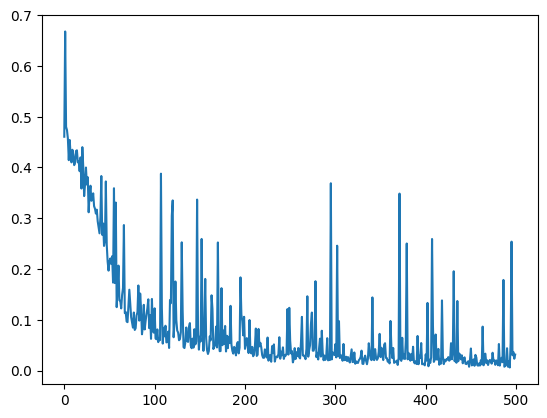

In [48]:
from diff_unet import train
%matplotlib inline
train(unet, optimizer, data_loader, epochs=500)

In [49]:
ims = diff_unet.sample(unet, height, batch_size=batch_size)
print(ims[0].shape)
print(len(ims))

Sampling: 0it [00:00, ?it/s]

torch.Size([1, 1, 28, 28])
200


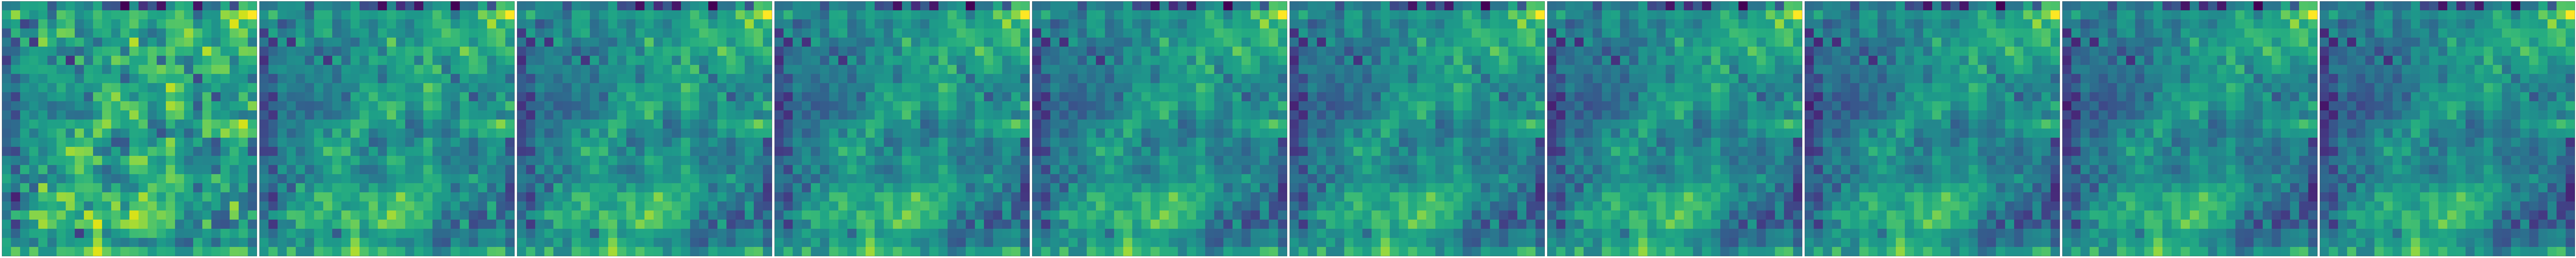

In [50]:
from plot_utils import row_plot

ims10 = ims[0:-1:20]
row_plot([im.view(1, height, width) for im in ims10])

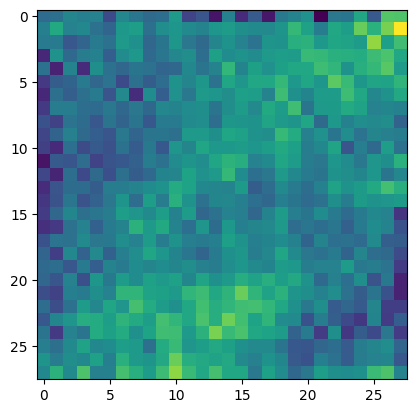

In [51]:
plt.imshow(ims[-1][0, 0, :, :].detach().numpy());

In [52]:
#for param in unet.parameters():
#    print(param.shape)

In [53]:
# Check activation saturation
# Nonlinearities used: GELU, SiLU (swish), softmax(attention)

#activs = set()

#for i, layer in enumerate(unet.modules()):
#    print(i, layer)